# <span style="color:#228B22">Covid-19 Classification using Transfer Learning
Deep Learning for Computer Vision - Winter Term 2023/24</span>

## <span style="color:#228B22">Topic</span>

In this exercise, we solve an image classification task from medical imaging: classification in Chest X-Ray images into patients with Covid-19, Pneunomia or Healthy. We will use a subset of the dataset from a kaggle challenge for this. (https://www.kaggle.com/datasets/prashant268/chest-xray-covid19-pneumonia)

The main focus of this exercise is transfer learning, and we will approach the classification task with three different approaches:

- Training ResNets from scratch. (Note that we will use the ResNet implementation from torchvision throughout the exercise).
- Training ResNets pretrained on ImageNet.
- Training ResNets pretrained on RadImageNet, a large radiology dataset.

In addition we can combine these approaches with other methods to improve the model at the end and upload your best solution on a hold-out test set.

### <span style="color:#228B22">Hints</span>

In the first part of the exercise we will train ResNets from scratch, analyze the effects of deeper models with small training data and use data augmentations. In the second part, we will solve the same task using pretrained ResNets (from ImageNet - pretrained on natural images; and RadImageNet - pretrained on the medical imaging domain).

To understand the background of this exercise:
- Review CNNs, Transfer Learning, and Augmentaion
- Check out the [RadImageNet publication](https://doi.org/10.1148/ryai.210315).

<span style="color:#228B22">**Importing required libraries**</span>

In [1]:
import os
from glob import glob
from IPython.display import FileLink

import numpy as np
import imageio.v3 as imageio
import matplotlib.pyplot as plt

import torch
import torchvision
from torch import nn
import torch.optim as optim
import torchvision.transforms as transforms

%pip install barbar

Note: you may need to restart the kernel to use updated packages.


In [2]:
# Setting up the device (make sure device returns "cuda" to use of the GPUs on kaggle)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### <span style="color:#228B22">Getting the Required Functionalities</span>

`ex3_utils.py` contains the implementation of functions necessary for training evaluation etc.


In [11]:
# Download `ex3_utils.py` from Google Drive in Kaggle
!conda install -y gdown

# File Location - https://drive.google.com/file/d/1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ/view?usp=sharing (we only need the id)
!gdown 1VfnvYTwNbDdwFArYZqZuqhkmw9d39IgQ

Retrieving notices: ...working... done
done
Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.1.2

Please update conda by running

    $ conda update -n base -c conda-forge conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.1.2



## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    filelock-3.13.1            |     pyhd8ed1ab_0          15 KB  conda-forge
    gdown-5.1.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    ------------------------------------------------------------
                                           Total:          36 KB

The following NEW packages will be INSTALLED:

  filelock           conda-forge/noarch::filelock-3.13.1-pyhd8ed1a

In [10]:
# If using Kaggle, add the .py file from the "Input" section on the right (upload as a dataset),
# then run this cell. If working locally, download the .py file and import it as usual

import sys
sys.path.append('/kaggle/input/ex3-utils')

import ex3_utils as utils

### <span style="color:#228B22">Data Preparation</span>

In [12]:
# Downloading the "Chest X-ray (Covid-19 & Pneumonia)" data from owncloud
!wget https://owncloud.gwdg.de/index.php/s/dcvhmxtksDDDtK8/download -O covid19-xray.zip

# Unzipping the dataset
!unzip -q "/kaggle/working/covid19-xray.zip"

--2024-03-18 13:35:09--  https://owncloud.gwdg.de/index.php/s/dcvhmxtksDDDtK8/download
Resolving owncloud.gwdg.de (owncloud.gwdg.de)... 134.76.23.45
Connecting to owncloud.gwdg.de (owncloud.gwdg.de)|134.76.23.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 154704441 (148M) [application/zip]
Saving to: 'covid19-xray.zip'

covid19-xray.zip    100%[===================>] 147.54M  10.7MB/s    in 16s     

2024-03-18 13:35:27 (9.34 MB/s) - 'covid19-xray.zip' saved [154704441/154704441]



In [13]:
# Setting the path to covid-19 dataset
root_dir = "/kaggle/working/"
data_folder = os.path.join(root_dir, "covid19")

<span style="color:#228B22">**Data exploration**</span>

The data is stored in the root folder `covid19` (in `"/data"`) and contains four subfolders, namely `train`, `val`, `test` and `unknown` with training / validation / testing split and the hold-out test set, respectively. Each of these (except `unknown`) contains subfolders with the images for the respective classes. As a first step, we will visualize some of the images and labels from the training data.

We will not use the `unknown` directory for training or evaluation, but will only use it for prediction with the best model at the end.

In [15]:
# Checking the number of classes
train_class_dirs = glob(os.path.join(data_folder, "train", "*"))
val_class_dirs = glob(os.path.join(data_folder, "val", "*"))
test_class_dirs = glob(os.path.join(data_folder, "test", "*"))

assert len(train_class_dirs) == len(val_class_dirs) == len(test_class_dirs) == 3

In [17]:
# Checking the expected structure of all images
image_paths = glob(os.path.join(data_folder, "**", "*.jpg"), recursive=True)
assert len(image_paths) == (450 + 150 + 225 + 5607), len(image_paths)  # 450 train samples, 150 val samples, 225 test samples, 5607 unlabeled samples (hold-out test)

Let's plot samples from each class in the training set:

/kaggle/working/covid19/train/PNEUMONIA


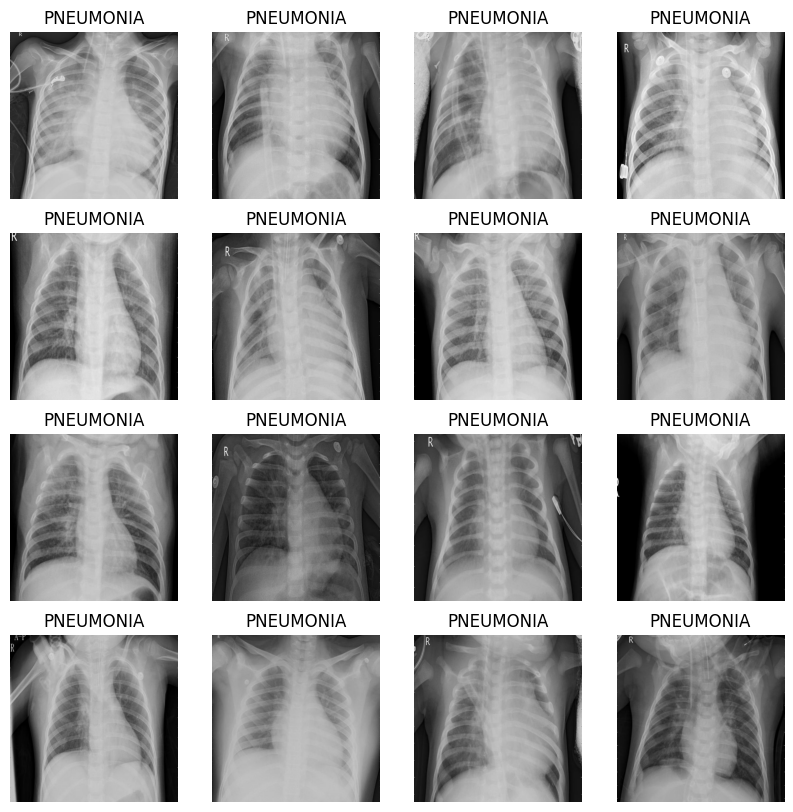

/kaggle/working/covid19/train/COVID19


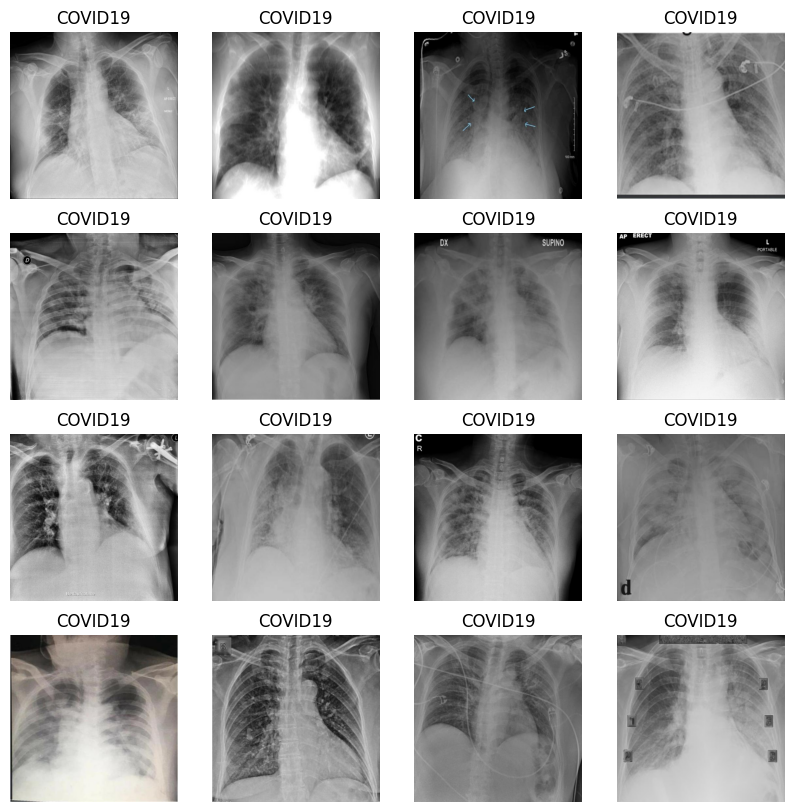

/kaggle/working/covid19/train/NORMAL


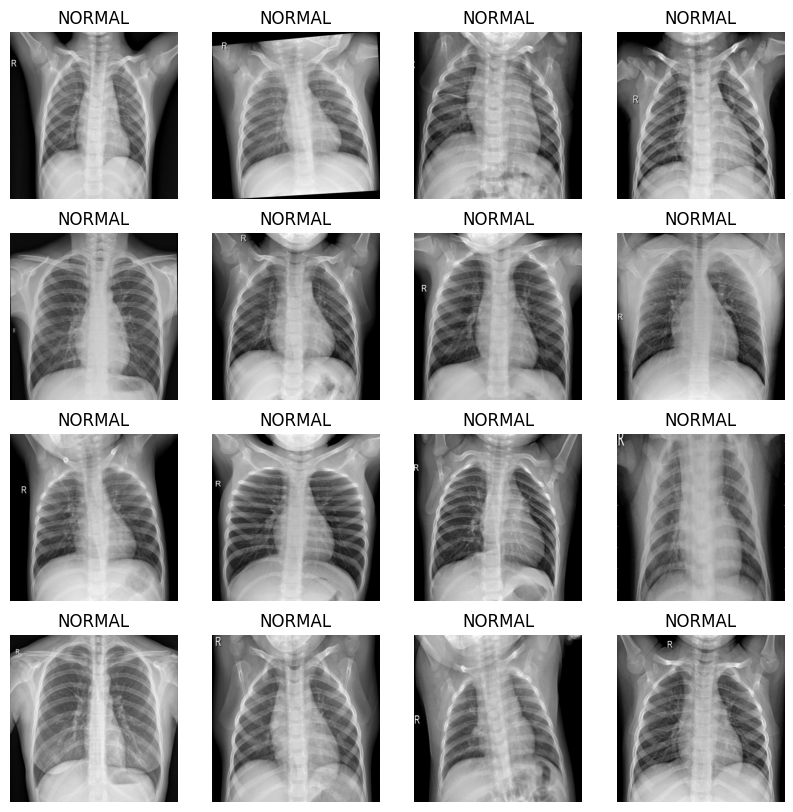

In [18]:
# Classes available for the task
classes = ["COVID19", "NORMAL", "PNEUMONIA"]
num_classes = 3

# TODO: YOUR SOLUTION HERE
for class_dir in train_class_dirs:
    print(class_dir)
    images = []
    # loop through first 16 filenames in class_dir 
    for filename in os.listdir(class_dir)[:16]:
            # load image 
            img_path = os.path.join(class_dir, filename)
            img = torchvision.io.read_image(img_path)
            # convert image to PIL image
            img = transforms.ToPILImage()(img)
            # add to image list
            images.append(img)
    
    # plot image list
    fig = plt.figure(figsize=(10, 10))
    for i, img in enumerate(images):
        plt.subplot(4, 4, i+1)
        plt.imshow(img)
        plt.title('{}'.format(os.path.basename(class_dir)))
        plt.axis('off')
    plt.show()

<span style="color:#228B22">**Comments**</span>

We can see x-ray images from each class and their corresponding labels in their titles.

- We can check the number of classes provided by the datasets:

In [19]:
print(len(train_class_dirs), len(val_class_dirs), len(test_class_dirs))

3 3 3


- And we can check whether the images are balanced along all the classes in the respective data splits:

In [20]:
for d in train_class_dirs:
    print(d, len(os.listdir(d)))
    
print()
for d in val_class_dirs:
    print(d, len(os.listdir(d)))
    
print()
for d in test_class_dirs:
    print(d, len(os.listdir(d)))

/kaggle/working/covid19/train/PNEUMONIA 150
/kaggle/working/covid19/train/COVID19 150
/kaggle/working/covid19/train/NORMAL 150

/kaggle/working/covid19/val/PNEUMONIA 50
/kaggle/working/covid19/val/COVID19 50
/kaggle/working/covid19/val/NORMAL 50

/kaggle/working/covid19/test/PNEUMONIA 75
/kaggle/working/covid19/test/COVID19 75
/kaggle/working/covid19/test/NORMAL 75


Let's set the directories for the respective datasets

In [21]:
# Splits for the dataset 
train_dir = os.path.join(data_folder, "train")
val_dir = os.path.join(data_folder, "val")
test_dir = os.path.join(data_folder, "test")
unknown_dir = os.path.join(data_folder, "unknown")

Now, we obtain the statistics (mean and standard deviation) from the training dataset to be used for normalizing the datasets

In [22]:
train_images = []
for class_name in classes:
    train_images.extend(glob(os.path.join(train_dir, class_name, "*.jpg")))

to_tensor = torchvision.transforms.ToTensor()
imgs = torch.stack([to_tensor(imageio.imread(im)) for im in train_images])
print(imgs.shape)

# And then compute the mean and standard deviation independently for the image channels.
# (The channels are stored in dim=1, by excluding this below we achieve this.)
mean = torch.mean(imgs, dim=(0, 2, 3))
std = torch.std(imgs, dim=(0, 2, 3))

# Delete the images again in order to save memory.
del imgs

print(mean)
print(std)

torch.Size([450, 3, 512, 512])
tensor([0.4949, 0.4952, 0.4957])
tensor([0.2298, 0.2298, 0.2298])


In [23]:
train_dataset_mean = mean
train_dataset_std = std

<span style="color:#228B22">**Implement PyTorch dataloader**</span>

As a next step, we implement a `torch.utils.data.Dataset` followed by the `torch.utils.data.DataLoader` to have access to our data during training, validation and testing. In our case, the data is stored in a format that is already compatible with `torchvision.datasets.ImageFolder`.

To use the image data in PyTorch it first needs to be transformed. We can use the transformations from [torchvision.transforms](https://pytorch.org/vision/0.9/transforms.html) for this. Here, we need to:
- Convert the image data to a `torch.tensor` (`transforms.ToTensor`)
- Standardize the inputs based on their data statistics (`transforms.Normalize`)
- Resize the images (`transforms.Resize`). Note that resizing is not strictly necessary, but will speed up training and resize the images to a size that better matches the ImageNet pretraining data.

To combine several transforms together, we can use `torchvision.transforms.Compose` by passing the list of 'transform' objects to compose.

In [53]:
# We resize the images to the size 256 x 256 to speed up training
height = width = 256

# Get the usual transforms to have the inputs from dataloaders as expected
def get_transforms(height, width, mean, std):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
        transforms.Resize((height, width), antialias=True)
    ])
    return transform

In [25]:
# Batch size
batch_size = 50  # Change if needed

# Datasets
transform = get_transforms(height, width,train_dataset_mean, train_dataset_std)
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Now let's visualize the images after transformation as they are returned from the training loader.

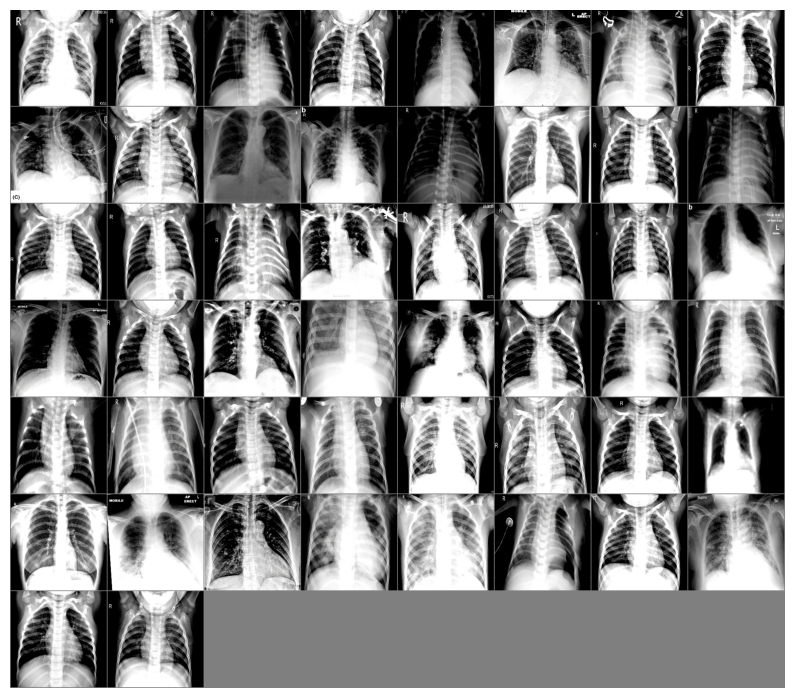

In [27]:
# Function to show images
fig = plt.figure(figsize=(10, 15))
def imshow(img):
    img = img / 2 + 0.5  # unnormalise
    npimg = img.numpy()
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Obtain random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show the images
imshow(torchvision.utils.make_grid(images))

#print(' '.join('%5s, ' % classes[labels[j]] for j in range(len(labels))))

## <span style="color:#228B22">Architecture</span>

We will use the ResNet implementation from torchvision, see https://pytorch.org/vision/stable/models.html, for this exercise.

- We start with the smallest ResNet model, the ResNet18 (https://pytorch.org/vision/main/models/generated/torchvision.models.resnet18.html)
- And will then use deeper ResNets to explore how well larger models can be trained on a small dataset.
- To use random weight initialization (in order to train from scratch), you can just create models without passing additional arguments as follows: `torchvision.models.<MODEL_NAME>()`.

We need to adapt the model to fit with our purpose. For this, we must change the output dimension of the last fully-connected layer to consider the number of classes in our problem. Let's check the last layer out.

In [28]:
# Let's get the resnet18 architecture and understanding the backbone (in order to adapt it to our problem)
model = torchvision.models.resnet18()
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

We see above that there is a component called `fc` that consists of a `Linear` layer. To make use of ResNet18 for our classification task, we need to change the `out_features` of the linear layer to the number of classes of our problem. In our case, it's `num_classes` (=3).

In [29]:
print(model.fc)

Linear(in_features=512, out_features=1000, bias=True)


To replace the last layer (classification layer) we can use the following code:

```python
import torchvision
import torch.nn as nn

model = torchvision.models.resnet18()

# Let's replace the "fully connected" layer to match our expected output classes
model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
model.to(device)
```

In [30]:
# Replacing the last layer(s) of ResNet18 to match our number of classes
model.fc = nn.Linear(512, num_classes)
model = model.to(device)

# Let's define the checkpoint name where the specific model checkpoint will be saved
model_name = 'myresnet18'
checkpoint_name = f'covid-19-{model_name}-from-scratch.pt'
checkpoint_path = os.path.join(root_dir, checkpoint_name)
print("The model checkpoint will be saved here: ", checkpoint_path)

The model checkpoint will be saved here:  /kaggle/working/covid-19-myresnet18-from-scratch.pt


If we now display the model (using `print(model)`) we should see that its last layer has been updated.

In [31]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### <span style="color:#228B22">Training</span>

Let's train the model for 10 epochs, using the `Adam` optimizer, `CrossEntropyLoss` as the criterion (loss function) and a learning rate scheduler (e.g. `ReduceLROnPlattorch.optim.lr_scheduler.ReduceLROnPlateaueau`).

In [32]:
# Clearing the GPU cache
torch.cuda.empty_cache()

print("Starting training from scratch with network: ", model_name)

lr = 0.0001
# Optimizer and loss configurations
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

# Initializing the early stopping of the training
early_stopping = utils.EarlyStopping(checkpoint_path)

# HINT: open the 'ex3_utils.py' file to understand the arguments of 'run_training'
accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, 
                                                                model, 10, criterion, 
                                                                optimizer, scheduler=scheduler,
                                                                early_stopping=early_stopping, device=device)

Starting training from scratch with network:  myresnet18
450/450: [============================>...] - ETA 1.2s
Epoch: 1
Training Loss: 0.701 , Training Accuracy:0.722 => Validation Loss: 1.622, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 0.3s
Epoch: 2
Training Loss: 0.882 , Training Accuracy:0.573 => Validation Loss: 0.642, Validation Accuracy: 0.700 
450/450: [============================>...] - ETA 0.3s
Epoch: 3
Training Loss: 0.515 , Training Accuracy:0.798 => Validation Loss: 0.521, Validation Accuracy: 0.800 
450/450: [============================>...] - ETA 0.3s
Epoch: 4
Training Loss: 0.443 , Training Accuracy:0.811 => Validation Loss: 0.648, Validation Accuracy: 0.813 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.3s
Epoch: 5
Training Loss: 0.391 , Training Accuracy:0.853 => Validation Loss: 0.565, Validation Accuracy: 0.733 
EarlyStopping Counter: 2 out of 5
450/450: [============================>...] -

Now, let's see how the accuracy and loss plots look for our training.

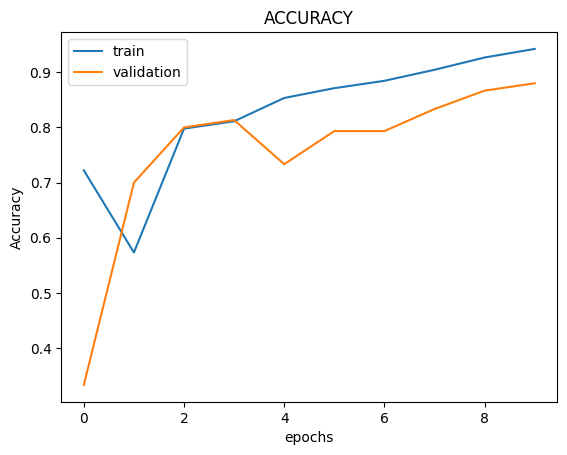

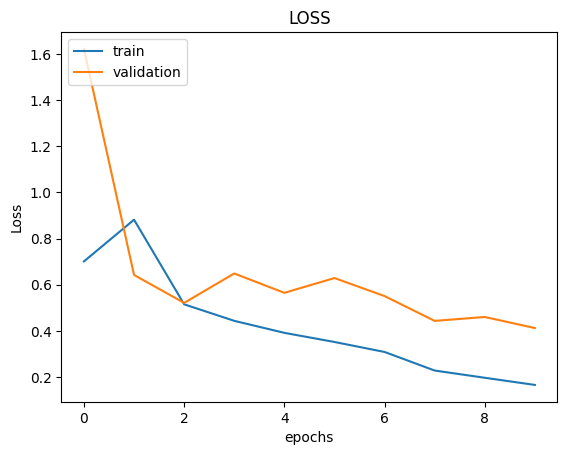

In [33]:
# Training and validation accuracy plots
utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")

# Training and validation loss plots
utils.get_metric_plots(losses, val_losses, "Loss")

### <span style="color:#228B22">Evalutaion on the test set</span>

Let's check the test accuracy and confusion matrix. All the required functionality is already provided in `ex3_utils.py`.

In [34]:
# Loading the best model for inference (NOTE: you should load the checkpoints to the expected model architecture, 
# otherwise you might get some mismatch errors)
model.load_state_dict(torch.load(checkpoint_path))

# Provide the testing dataset wrapped in a dataloader to check for inference
correct, total = utils.test_evaluation(model, test_loader, device)
print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

Accuracy of /kaggle/working/covid-19-myresnet18-from-scratch.pt on the Test Images: 89 %


In [35]:
# Get the confusion matrix for the test dataset
cm = utils.get_confusion_matrix(classes, test_loader, model, device)

# See the precision, recall and accuracy per class for the test dataset
utils.check_precision_recall_accuracy(cm, classes)

COVID19 - recall :  0.9375  precision :  1.0  accuracy :  0.9777778
NORMAL - recall :  0.8648649  precision :  0.85333335  accuracy :  0.9066667
PNEUMONIA - recall :  0.8873239  precision :  0.84  accuracy :  0.9111111


0.8977777777777778


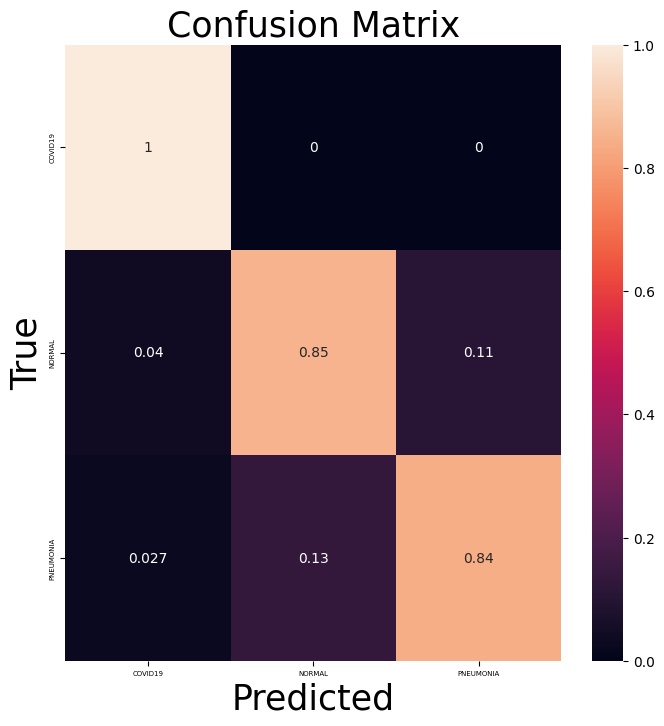

In [36]:
# Check the confusion matrix heatmap to visually see the evaluation on the test set
utils.visualize_confusion_matrix(cm, classes, correct, total)

Now let's try training deeper ResNet architectures using the same hyperparameters from above:
- Train and evaluate a ResNet34 from scratch.
- Train and evaluate a ResNet50 from scratch.

HINT (for the workflow):
- Start with training a ResNet34:
    - Updating the last layers (training the network from scratch)
    - REMEMBER: Save the respective checkpoints uniquely, and initialize the early stopping with them.
    - Use the expected hyperparameters for training
    - Observe the loss and accuracy curves for training and validation
- Next, train a ResNet50 (following the same suggestion as above)
- Finally, evaluate both the trained models from above on the test set and answer the questions.

In [37]:
# Put things we will use over and over again into a function

def train(model, model_name, train_loader, val_loader, test_loader, num_epochs, device, classes, root_dir):
    # Let's define the checkpoint name where the specific model checkpoint will be saved
    checkpoint_name = f'covid-19-{model_name}.pt'
    checkpoint_path = os.path.join(root_dir, checkpoint_name)
    print("The model checkpoint will be saved here: ", checkpoint_path)

    # Clearing the GPU cache
    torch.cuda.empty_cache()

    print("Starting training with network: ", model_name)

    lr = 0.0001
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(),lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)

    # Initializing the early stopping of the training
    early_stopping = utils.EarlyStopping(checkpoint_path)

    accuracy, val_accuracy, losses, val_losses = utils.run_training(train_loader, val_loader, 
                                                                    model, num_epochs, criterion, 
                                                                    optimizer, scheduler=scheduler,
                                                                    early_stopping=early_stopping, device=device)

    # Training and validation accuracy plots
    utils.get_metric_plots(accuracy, val_accuracy, "Accuracy")

    # Training and validation loss plots
    utils.get_metric_plots(losses, val_losses, "Loss")

    # Loading the best model for inference
    model.load_state_dict(torch.load(checkpoint_path))

    # Provide the testing dataset wrapped in a dataloader to check for inference
    correct, total = utils.test_evaluation(model, test_loader, device)
    print(f'Accuracy of {checkpoint_path} on the Test Images: %d %%' % (100 * correct / total))

    # Get the confusion matrix for the test dataset
    cm = utils.get_confusion_matrix(classes, test_loader, model, device)

    # See the precision, recall and accuracy per class for the test dataset
    utils.check_precision_recall_accuracy(cm, classes)

    # Check the confusion matrix heatmap to visually see the evaluation on the test set
    utils.visualize_confusion_matrix(cm, classes, correct, total)

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet34-from-scratch.pt
Starting training with network:  resnet34-from-scratch
450/450: [============================>...] - ETA 0.4s
Epoch: 1
Training Loss: 0.786 , Training Accuracy:0.660 => Validation Loss: 2.921, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 0.4s
Epoch: 2
Training Loss: 1.656 , Training Accuracy:0.402 => Validation Loss: 0.961, Validation Accuracy: 0.507 
450/450: [============================>...] - ETA 0.4s
Epoch: 3
Training Loss: 0.757 , Training Accuracy:0.636 => Validation Loss: 0.728, Validation Accuracy: 0.613 
450/450: [============================>...] - ETA 0.4s
Epoch: 4
Training Loss: 0.682 , Training Accuracy:0.716 => Validation Loss: 0.697, Validation Accuracy: 0.687 
450/450: [============================>...] - ETA 0.4s
Epoch: 5
Training Loss: 0.597 , Training Accuracy:0.733 => Validation Loss: 0.699, Validation Accuracy: 0.733 
EarlyStopping Counter: 

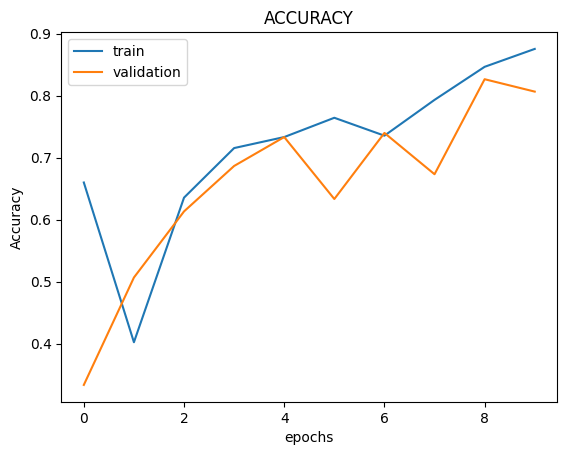

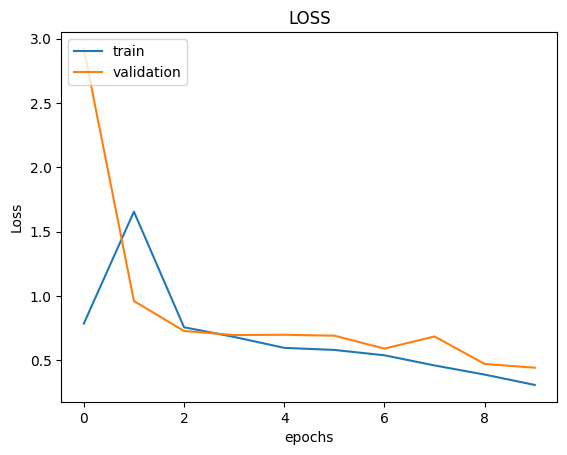

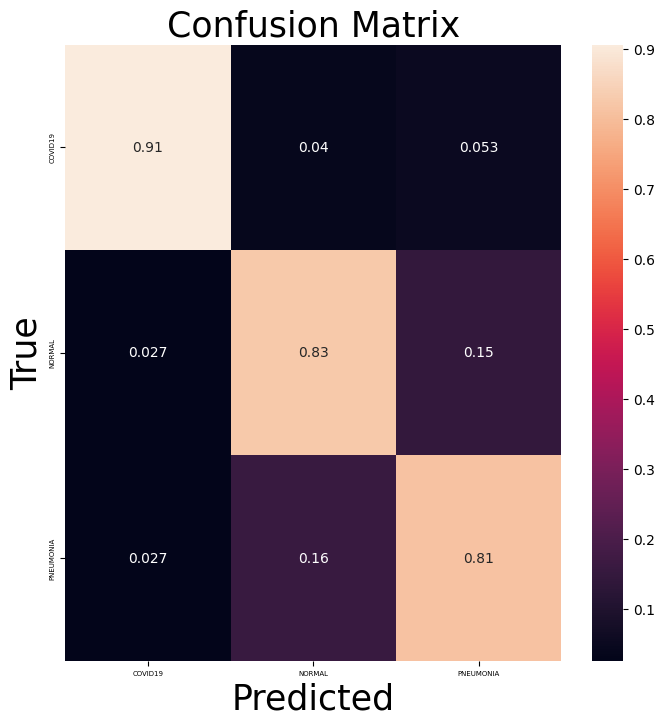

In [54]:
# ResNet34 from scratch
model = torchvision.models.resnet34()
model.fc = nn.Linear(512, num_classes)
model = model.to(device)

train(model, 'resnet34-from-scratch', train_loader, val_loader, test_loader, 10, device, classes, root_dir)

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50-from-scratch.pt
Starting training with network:  resnet50-from-scratch


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


450/450: [============================>...] - ETA 0.5s
Epoch: 1
Training Loss: 0.949 , Training Accuracy:0.578 => Validation Loss: 1.895, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 0.5s
Epoch: 2
Training Loss: 1.290 , Training Accuracy:0.324 => Validation Loss: 1.132, Validation Accuracy: 0.333 
450/450: [============================>...] - ETA 0.5s
Epoch: 3
Training Loss: 1.099 , Training Accuracy:0.340 => Validation Loss: 1.077, Validation Accuracy: 0.393 
450/450: [============================>...] - ETA 0.5s
Epoch: 4
Training Loss: 1.015 , Training Accuracy:0.569 => Validation Loss: 0.973, Validation Accuracy: 0.507 
450/450: [============================>...] - ETA 0.5s
Epoch: 5
Training Loss: 1.005 , Training Accuracy:0.487 => Validation Loss: 0.988, Validation Accuracy: 0.453 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.5s
Epoch: 6
Training Loss: 0.855 , Training Accuracy:0.647 => Validation Loss: 0.789

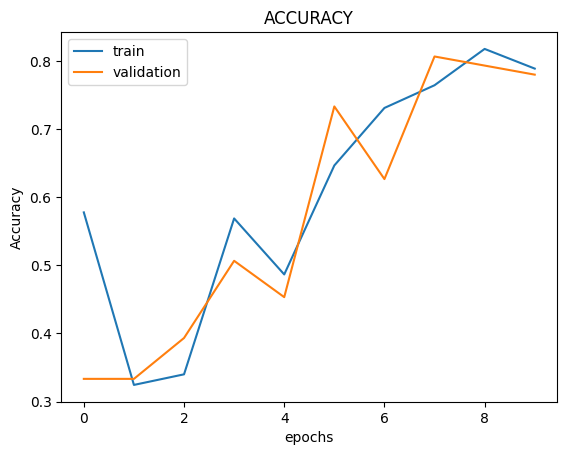

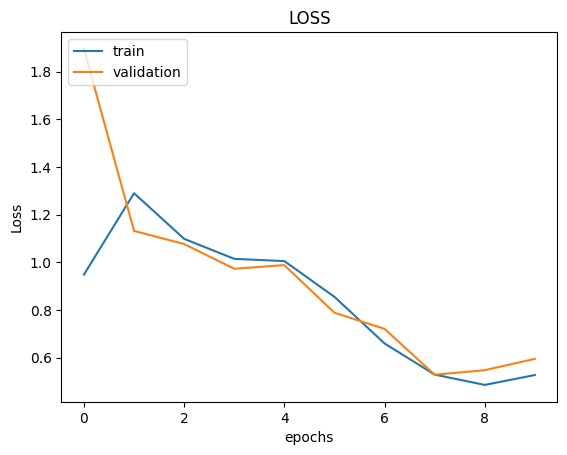

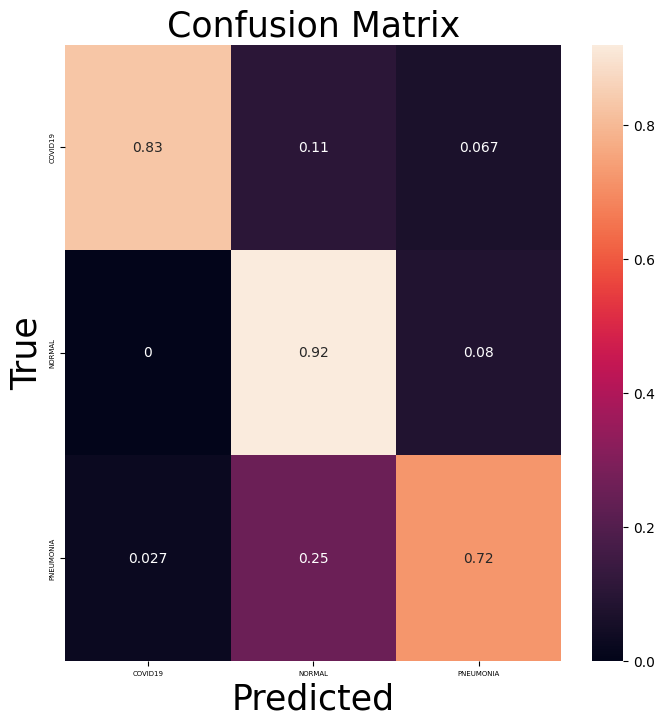

In [39]:
# ResNet50 from scratch
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, num_classes)
model = model.to(device)

train(model, 'resnet50-from-scratch', train_loader, val_loader, test_loader, 10, device, classes, root_dir)

<span style="color:#228B22">**Comments**</span>

1. We obtained the best result using resnet34. However, the accuracy was very close to the one we obtained using resnet18. The diagnose "Covid" is almost always correct. On the other hand, "normal" and "pneumonia" are misclassified quite often.
2. A bigger dataset should help the learning process in that it better represents the data distribution. However, in order to learn this representation, deeper networks may be needed.
3. Given the above observations, we'd prefer to start from a simple model and see if it's able to learn the representation. We would than switch to a deeper model if needed.

#### <span style="color:#228B22">New let's try using Data Augmentation</span>

A common strategy when dealing with small datasets is to add data augmentations.

Let's try a few augmentations from [torchvision.transforms](https://pytorch.org/vision/main/transforms.html) that do not significantly distort the data (stay on the data manifold) and train a ResNet50. Here, we want to see if augmentations allow us to train deeper CNNs. 
Common augmentations for data augmentation are:
- flipping the inputs along the axes.
- changing the brightness, contrast and saturation of the inputs.
- adding small noise to the input.

We can add augmentations by updating the `transform` passed to the train dataset. We can again use `Compose` to chain augmentations.

**Note**: only introduce augmentation for the training and validation datasets, **not** for the test dataset. Otherwise the evaluation between models is not consistent anymore.

In [40]:
def get_transforms_augment(height, width, mean, std):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.RandomHorizontalFlip(0.3),
        #transforms.RandomVerticalFlip(0.2),
        transforms.ColorJitter((0.2,1.2), (0.2,1.2)),
        #transforms.RandomCrop(size=(128,128)),
        transforms.Normalize(mean, std),
        transforms.Resize((height, width))
    ])
    return transform

We need to apply the new transforms to the dataset and then use our dataloader. Let's reuse our scripts from above, now with the added data augmentation strategies.

In [42]:
transform1 = get_transforms(height, width,train_dataset_mean, train_dataset_std)
transform2 = get_transforms_augment(height, width,train_dataset_mean, train_dataset_std)

# Datasets
train_dataset_1 = torchvision.datasets.ImageFolder(root=train_dir, transform=transform1)
train_dataset_2 = torchvision.datasets.ImageFolder(root=train_dir, transform=transform2)
train_dataset = torch.utils.data.ConcatDataset([train_dataset_1,train_dataset_2])

val_dataset_1 = torchvision.datasets.ImageFolder(root=val_dir, transform=transform1)
val_dataset_2 = torchvision.datasets.ImageFolder(root=val_dir, transform=transform2)
val_dataset = torch.utils.data.ConcatDataset([val_dataset_1, val_dataset_2])

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

Now, we are ready to train the ResNet50 with data augmentations. Let's train for longer (30 epochs) here, with the same hyperparameters as before, and evaluate the model on the test set.

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50-from-scratch-augmented.pt
Starting training with network:  resnet50-from-scratch-augmented


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


900/900: [==============================>.] - ETA 0.6s
Epoch: 1
Training Loss: 1.009 , Training Accuracy:0.523 => Validation Loss: 1.264, Validation Accuracy: 0.320 
900/900: [==============================>.] - ETA 0.6s
Epoch: 2
Training Loss: 1.155 , Training Accuracy:0.356 => Validation Loss: 1.136, Validation Accuracy: 0.450 
900/900: [==============================>.] - ETA 0.6s
Epoch: 3
Training Loss: 1.043 , Training Accuracy:0.446 => Validation Loss: 0.935, Validation Accuracy: 0.603 
900/900: [==============================>.] - ETA 0.6s
Epoch: 4
Training Loss: 0.846 , Training Accuracy:0.618 => Validation Loss: 0.781, Validation Accuracy: 0.673 
900/900: [==============================>.] - ETA 0.6ss
Epoch: 5
Training Loss: 0.679 , Training Accuracy:0.691 => Validation Loss: 0.773, Validation Accuracy: 0.677 
900/900: [==============================>.] - ETA 0.6s
Epoch: 6
Training Loss: 0.683 , Training Accuracy:0.684 => Validation Loss: 0.830, Validation Accuracy: 0.680 
Ear

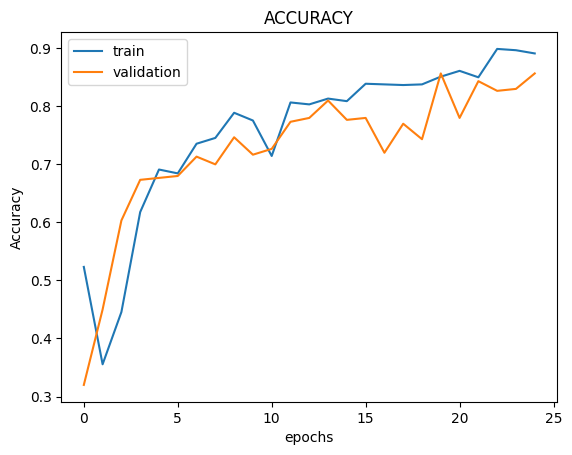

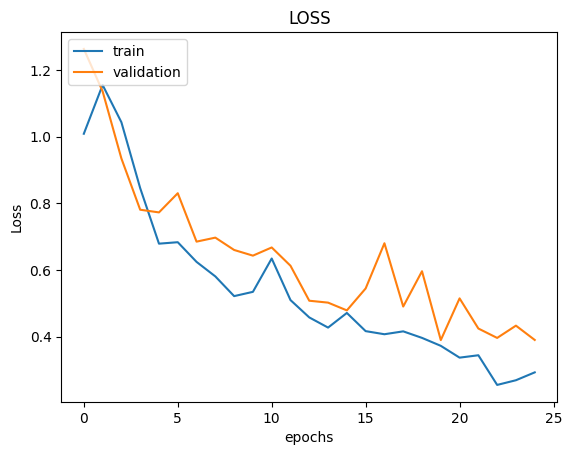

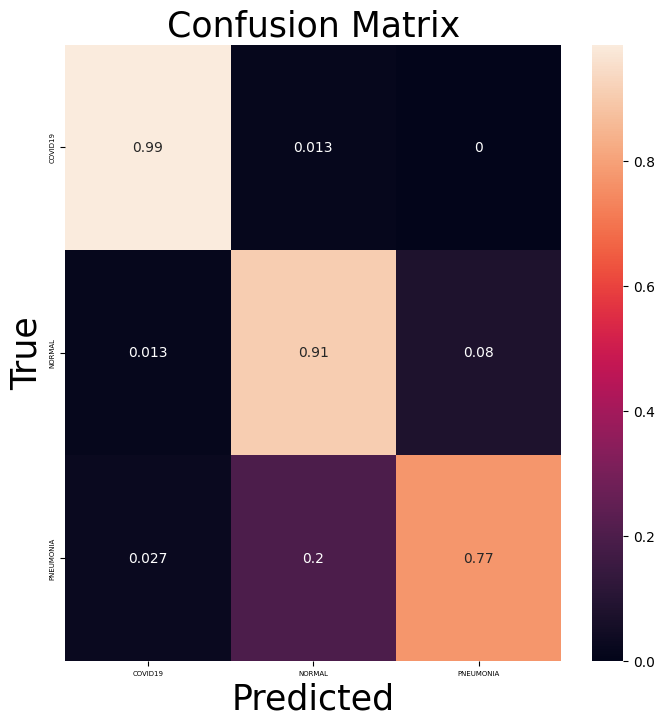

In [43]:
# ResNet50 from scratch with augmentation
model = torchvision.models.resnet50()
model.fc = nn.Linear(2048, num_classes)
model = model.to(device)

train(model, 'resnet50-from-scratch-augmented', train_loader, val_loader, test_loader, 30, device, classes, root_dir)

<span style="color:#228B22">**Comments**</span>

1. The effect of data augmentation matches the expectations. We are able to go from 81\% to 88\% accuracy on the test set.
2. Other kinds of adata augmentations that would make sense for this dataset include random noise, e.g., using gaussian blur or gaussian noise. We could also randomly crop the image or rotate it. Another possibility would be to use shearing.

## ImageNet

The [ImageNet project](https://www.image-net.org/) provides a large-scale dataset with natural images. There exist different version of this dataset, the largest using 14 million annotated images for image classification with over 20,000 categories. 

This dataset has been used by the ImageNet Scale Visual Recognition Challenge ([ILSVRC](https://image-net.org/challenges/LSVRC/#:~:text=The%20ImageNet%20Large%20Scale%20Visual,image%20classification%20at%20large%20scale.)) to benchmark classification algorithms competing to improve classification. The version fo the dataset used for this classification contains a million training images with 1,000 categeories.

`torchvision.models` has a pool of neural networks, for which pretrained ImageNet weights are also available. To make use of pretrained models, we need to preprocess the images based on the mean and standard deviation of ImageNet (**this step is critical!**). The statistics for ImageNet are provided [here](https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html#:~:text=1.0%5D%20and%20then-,normalized%20using%20mean%3D%5B0.485%2C%200.456%2C%200.406%5D%20and%20std%3D%5B0.229%2C%200.224%2C%200.225%5D.,-Next)

### ImageNet transfer learning for ResNet50

We will now check if transfer learning from ImageNet leads to improvements for our dataset. Here, we will focus on the ResNet50 as we have seen before that without transfer learning its performance is worse compared to smaller architectures for our dataset.

There are two different approaches for how we can fine-tune a CNN initialized with pretrained weights:
1. Update the weights for all layers of the network. For this approach we initialize with pretrained weights but otherwise train the network as before. See this code snippet:
   
    ```python
    import torchvision
    import torch.nn as nn

    model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)

    # Let's replace the "fully connected" layer to match our expected output classes
    model.fc = nn.Linear(<INPUT_FEATURES>, <OUTPUT_CLASSES>)
    model.to(device)

    # Train the network as usual
    ```

2. Only update the weights of the last layer (classification layer). In this case we would "freeze" the pretrained network and use it as a fixed feature extractor. This is achieved by disabling parameter updates for all but the last layer of the network.

We will start with the **first approach** (fine-tuning the full network).

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:03<00:00, 27.9MB/s]


The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50-imagenet_all_layers.pt
Starting training with network:  resnet50-imagenet_all_layers


/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


450/450: [============================>...] - ETA 0.5s
Epoch: 1
Training Loss: 0.947 , Training Accuracy:0.696 => Validation Loss: 0.889, Validation Accuracy: 0.820 
450/450: [============================>...] - ETA 0.5s
Epoch: 2
Training Loss: 0.418 , Training Accuracy:0.889 => Validation Loss: 0.322, Validation Accuracy: 0.887 
450/450: [============================>...] - ETA 0.5s
Epoch: 3
Training Loss: 0.129 , Training Accuracy:0.960 => Validation Loss: 0.134, Validation Accuracy: 0.947 
450/450: [============================>...] - ETA 0.5s
Epoch: 4
Training Loss: 0.044 , Training Accuracy:0.987 => Validation Loss: 0.302, Validation Accuracy: 0.913 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.5s
Epoch: 5
Training Loss: 0.010 , Training Accuracy:0.996 => Validation Loss: 0.200, Validation Accuracy: 0.940 
EarlyStopping Counter: 2 out of 5
450/450: [============================>...] - ETA 0.5s
Epoch: 6
Training Loss: 0.002 , Training Accura

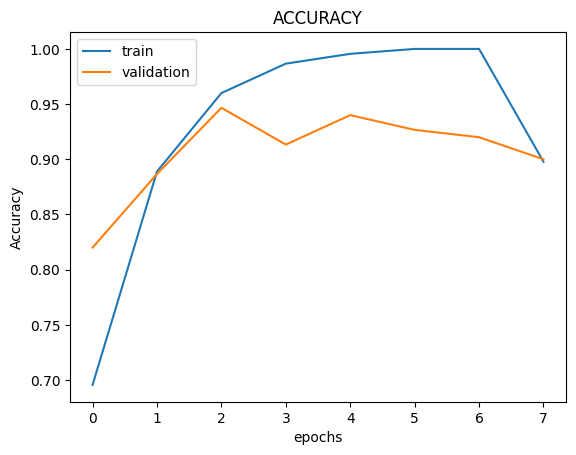

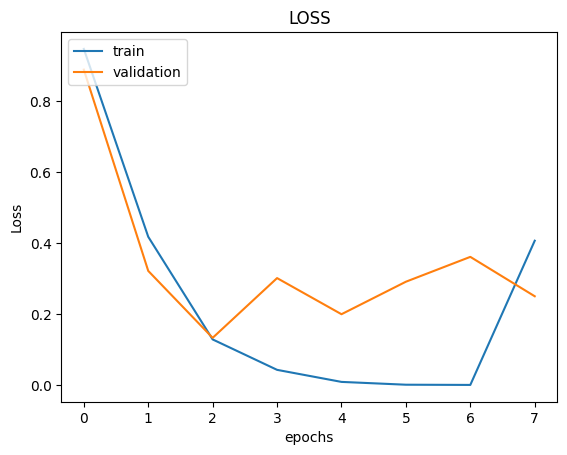

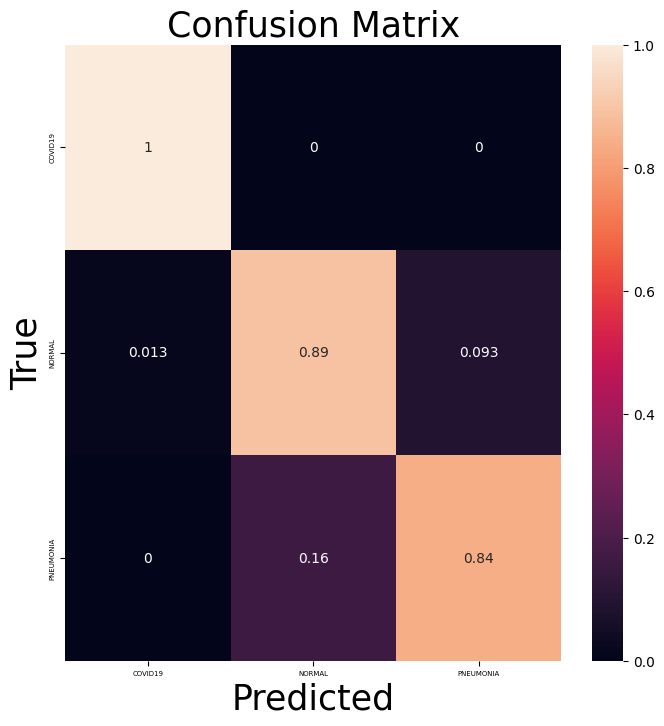

In [44]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(2048, num_classes)
model = model.to(device)

# new datasets with imagenet mean and std

# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

transform = get_transforms(height, width, imagenet_mean, imagenet_std)

# Datasets
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# train as usual
train(model, 'resnet50-imagenet_all_layers', train_loader, val_loader, test_loader, 30, device, classes, root_dir)

Now let's try the **second approach** and finetune only the last layer.

By default all parameters of a network will be updated by gradient descent. The gradient updates can be disabled by setting `requires_grad = False`. So in order to finetune only the last layer you need to `requires_grad = False` for all other layers in the network.

The code snippet below shows how the parameters are disabled for a complete model. For the next exercise we need to make sure that `requires_grad` stays `True` for the last layer!

```python
for param_name, param in model.named_parameters():
    param.requires_grad = False
```

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50-imagenet_last_layer.pt
Starting training with network:  resnet50-imagenet_last_layer
 50/450: [>...............................] - ETA 0.0s

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


450/450: [============================>...] - ETA 0.3s
Epoch: 1
Training Loss: 1.085 , Training Accuracy:0.407 => Validation Loss: 1.086, Validation Accuracy: 0.433 
450/450: [============================>...] - ETA 0.3s
Epoch: 2
Training Loss: 1.077 , Training Accuracy:0.447 => Validation Loss: 1.059, Validation Accuracy: 0.493 
450/450: [============================>...] - ETA 0.3s
Epoch: 3
Training Loss: 1.048 , Training Accuracy:0.522 => Validation Loss: 1.031, Validation Accuracy: 0.567 
450/450: [============================>...] - ETA 0.3s
Epoch: 4
Training Loss: 1.019 , Training Accuracy:0.622 => Validation Loss: 1.002, Validation Accuracy: 0.700 
450/450: [============================>...] - ETA 0.3s
Epoch: 5
Training Loss: 0.990 , Training Accuracy:0.720 => Validation Loss: 0.974, Validation Accuracy: 0.787 
450/450: [============================>...] - ETA 0.3s
Epoch: 6
Training Loss: 0.962 , Training Accuracy:0.802 => Validation Loss: 0.948, Validation Accuracy: 0.807 
450/

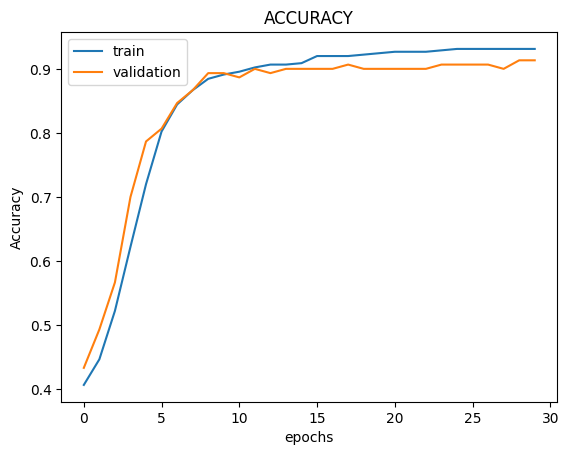

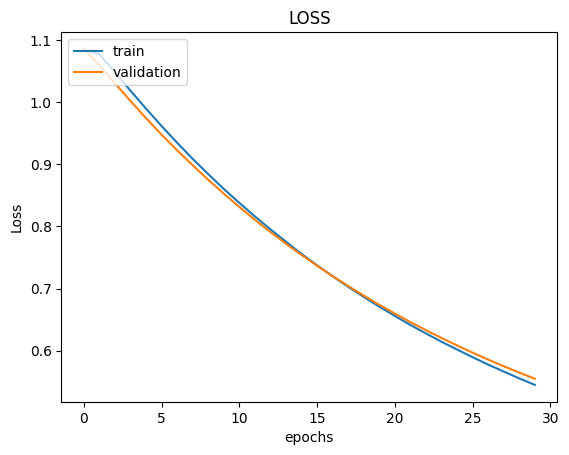

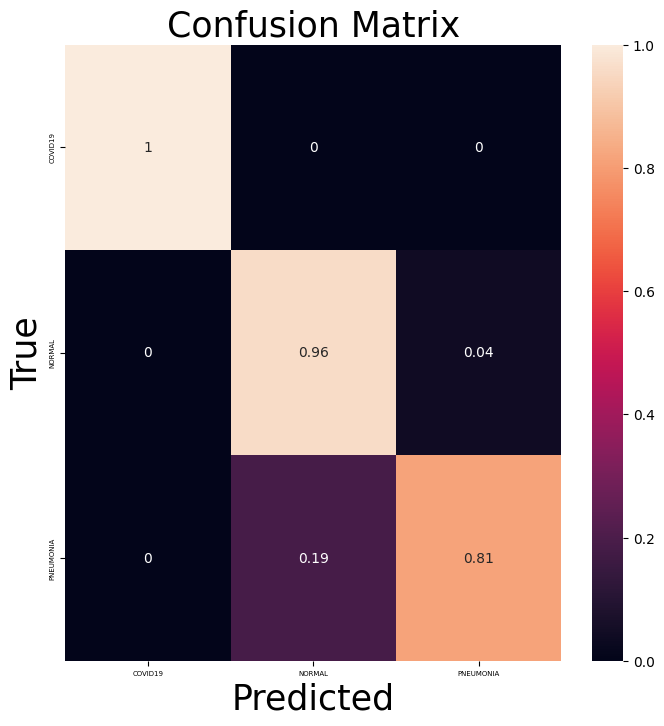

In [45]:
model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(2048, num_classes)

for param_name, param in model.named_parameters():
    # print(param_name)
    if not param_name.startswith("fc"):
        param.requires_grad = False

model = model.to(device)

# train as usual
train(model, 'resnet50-imagenet_last_layer', train_loader, val_loader, test_loader, 30, device, classes, root_dir)

<span style="color:#228B22">**Comments**</span>

1. It is easier to build on top of a well-performing model than building a completely new one from scratch. This is partially because an already trained model "knows" how to perform tasks such as edge detection. As a consequence, all is needed is to adapt this ability to new images.  
2. The first transfer learning approach (training the whole network again) resulted in slightly better performances
3. When dealing with a dataset similar to the one ImageNet was trained on it would probably better to use the second approach. This is because only some fine-tuning would be needed. However, when working with very different datasets it would probably be better to re-train the whole network in order to fit the parameters to the new dataset.
4. When finetuning a model it may also be beneficial to use a different learning rate and change other hyperparameters compared to training from scratch. To keep the exercise simple we do not further explore these options here.

## <span style="color:#228B22">RadImageNet</span>

A disadvantage of using ImageNet pretraining for medical images is that the pretraining data is very different to medical images. There are several efforts to build pretraining datasets for the medical image domain, for example [RadImageNet](https://www.radimagenet.com/).
It contains a pretraining dataset made up of radiology images of a comparable size to ImageNet and provides networks that were pretrained with this dataset.
- For more details you can check out the [RadImageNet publication](https://doi.org/10.1148/ryai.210315).

**Note**: if you use on RadImageNet weights you will have to use the statistics below for normalization (corresponding to the image statistics of the RadImageNet dataset):
```python
# Normalization: mean and standard deviation values for the pretrained weights on radimagenet dataset
radimagenet_mean = (0.223, 0.223, 0.223)
radimagenet_std = (0.203, 0.203, 0.203)
```

We now use pretrained RadImageNet weights for the ResNet50. For this we first need to download those weights and then initialize the architecture correctly. (This is a bit more complex compared to before, so we give you the code for this below.)

In [46]:
# downloading the radimagenet pretrained model weights
# radimagenet weights - https://drive.google.com/file/d/1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR/view
! gdown 1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR

!unzip -q "/kaggle/working/RadImageNet_pytorch.zip" -d "RadImageNet_Models"

Downloading...
From (original): https://drive.google.com/uc?id=1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR
From (redirected): https://drive.google.com/uc?id=1RHt2GnuOYlc_gcoTETtBDSW73mFyRAtR&confirm=t&uuid=515c32bf-2858-4502-965b-becf26a787a4
To: /kaggle/working/RadImageNet_pytorch.zip
100%|████████████████████████████████████████| 195M/195M [00:06<00:00, 29.8MB/s]


In [47]:
radimagenet_checkpoint_path = "/kaggle/working/RadImageNet_Models/RadImageNet_pytorch"

resnet50_ckpt = torch.load(os.path.join(radimagenet_checkpoint_path, "ResNet50.pt"))

In [48]:
# We create the backbone to intialize it with the pretrained weights from radimagenet
class Backbone(nn.Module):
    def __init__(self):
        super().__init__()
        base_model = torchvision.models.resnet50()
        encoder_layers = list(base_model.children())
        self.backbone = nn.Sequential(*encoder_layers[:9])
                        
    def forward(self, x):
        return self.backbone(x)


# We build the classifier to use the features for transfer learning
class Classifier(nn.Module):
    def __init__(self, num_class):
        super().__init__()
        self.drop_out = nn.Dropout()
        self.linear = nn.Linear(2048, num_class)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.drop_out(x)
        x = self.linear(x)
        return x

## <span style="color:#228B22">Architecture</span>

We now combine the backbone (ResNet50 pretrained on RadImageNet) and the classification layer for our dataset.

Train and evaluate this model. You can decide wheter to finetune the whole model or just the last layer.

In [49]:
# Let's call the backbone (the encoder excluding the last layers)
backbone = Backbone()

# Loading the pretrained weights to the backbone
backbone.load_state_dict(resnet50_ckpt)

# Now let's call the expected fully connected layer
classifier = Classifier(num_class=len(classes))

# Finally, we are ready to build our model 
model = nn.Sequential(backbone, classifier)

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50-radimagenet_last_layer.pt
Starting training with network:  resnet50-radimagenet_last_layer
 50/450: [>...............................] - ETA 0.0s

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


450/450: [============================>...] - ETA 0.3s
Epoch: 1
Training Loss: 1.086 , Training Accuracy:0.402 => Validation Loss: 1.079, Validation Accuracy: 0.540 
450/450: [============================>...] - ETA 0.3s
Epoch: 2
Training Loss: 1.073 , Training Accuracy:0.580 => Validation Loss: 1.071, Validation Accuracy: 0.520 
450/450: [============================>...] - ETA 0.3s
Epoch: 3
Training Loss: 1.062 , Training Accuracy:0.618 => Validation Loss: 1.061, Validation Accuracy: 0.587 
450/450: [============================>...] - ETA 0.3s
Epoch: 4
Training Loss: 1.053 , Training Accuracy:0.636 => Validation Loss: 1.052, Validation Accuracy: 0.627 
450/450: [============================>...] - ETA 0.3s
Epoch: 5
Training Loss: 1.042 , Training Accuracy:0.638 => Validation Loss: 1.042, Validation Accuracy: 0.633 
450/450: [============================>...] - ETA 0.3s
Epoch: 6
Training Loss: 1.031 , Training Accuracy:0.644 => Validation Loss: 1.032, Validation Accuracy: 0.647 
450/

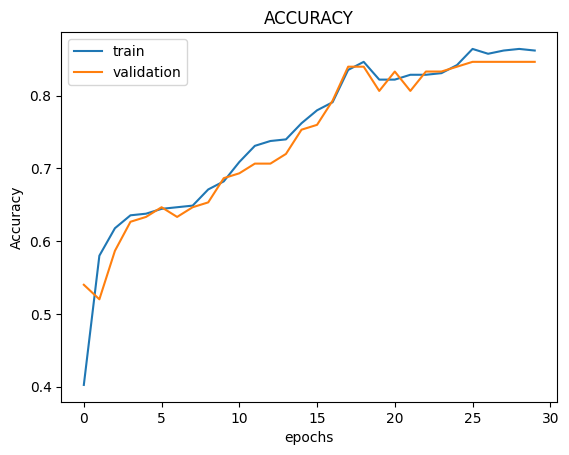

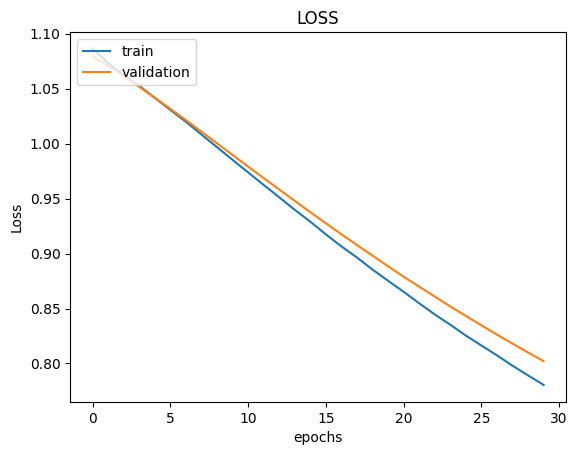

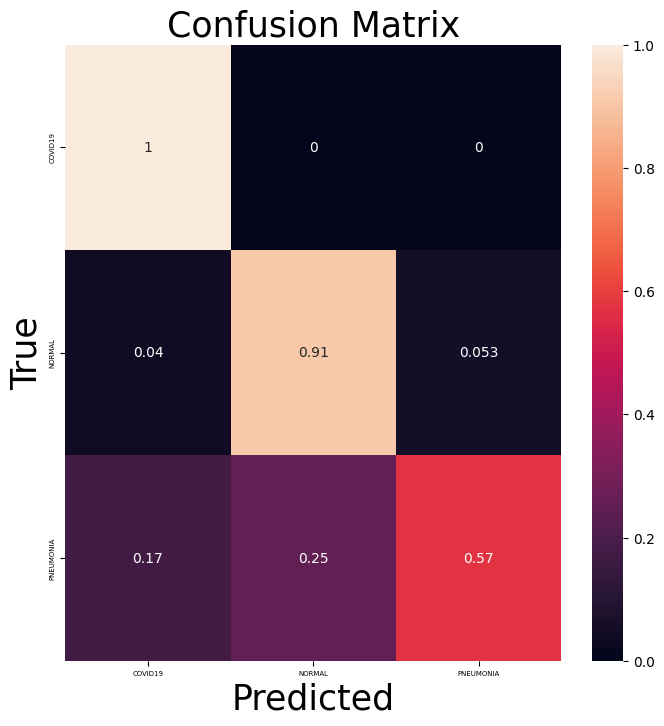

In [50]:
# Training a ResNet50 (updating all / last layers, transfer learning using RadImageNet weights) (the training workflows are the same as above)

# update only last layer
for param_name, param in model.named_parameters():
    if "backbone" in param_name:
        param.requires_grad = False

model.to(device)

# new datasets with radimagenet mean and std
radimagenet_mean = (0.223, 0.223, 0.223)
radimagenet_std = (0.203, 0.203, 0.203)

transform = get_transforms(height, width, radimagenet_mean, radimagenet_std)

# Datasets
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# train as usual
train(model, 'resnet50-radimagenet_last_layer', train_loader, val_loader, test_loader, 30, device, classes, root_dir)

<span style="color:#228B22">**Comments**</span>

1. We decided to only train the last layer. This is because RadImage was trained on medical images, which are quite similar to our dataset. However, the results are surprisingly bad.

### <span style="color:#228B22">Overall Results</span>

The table below contains the results for all experiments from the exercise:

| Model    | Training                         | Test Accuracy |
|:-------: |:--------------------------------:|:-------------:|
| ResNet18 | from scratch                     |         87%      |
| ResNet34 | from scratch                     |         83%      |
| ResNet50 | from scratch                     |         81%      |
| ResNet50 | from scratch (with augmentation) |         88%      |
| ResNet50 | from ImageNet (all layers)       |         93%      |
| ResNet50 | from ImageNet (last layers)      |         92%      |
| ResNet50 | from RadImageNet (last layers)   |         84%      |

<span style="color:#228B22">**Comments**</span>

1. Using transfer learning from ImageNet worked better than training ResNet50 from scratch.
2. The overall best model appears to be ResNet50 from ImageNet (all layers). This did not match our expectations, as we thought that ResNet50 from RadImageNet would perform best.

## <span style="color:#228B22">Further Improvements on the Model</span>

Improving the model can be done by using using different architectures or trying some advanced training and inference techniques. 

Possible approaches to improve the model include:
1. Updating the training hyperparameter:
    - You can choose a better initial learning rate, or choose different options for the learning rate scheduler or early stopping.
    - The most important parameter is probably the learning rate; if you want to improve it then train only for a short time and compare different values. (Remember lecture 2 and the first exercise). 
2. Trying other architectures provided in `torchvision.models`, which implements further CNN architectures (and their respective ImageNet pretrained weights). For example `DenseNet` or `EfficientNet` could yield better results than ResNets.
    - `torchvision.models` also offers vision transformer architectures (https://arxiv.org/abs/2010.11929). We will cover those later in the lecture, but if you want you can try them here as well. See the snippet at the end of this section for details. 
3. Trying advanced data augmentation strategies, which change the data manifold severly and can boost performance. For example MixUp or CutMix. `torchivsion` already implements them, see [data augmentation with torchvision](https://pytorch.org/vision/stable/transforms.html) for details.
4. Trying test-time data augmentation. We have covered this idea in the lecture. To use it you don't need to change the training at all, but just update the model prediction during testing. Fot this you can either update the functionality in `ex3_utils.py` or implement a wrapper function or class around the model that implements the test-time data augmentation logic.
5. Trying model ensembling: combine the predictions of different models on the test set or use an implicit averaging approach like polyak averaging. For this approaches you may need to update the training and/or prediction functions from `ex3_utils.py`.

Here's a snippet that shows how to use vision transformers from torchvision:

```python
# replacing the respective layers of the "transformer-based networks" to match our number of classes
net = torchvision.models.vit_b_16(pretrained=True)
net.heads.head = nn.Linear(768, num_classes)
net.to(device)
```

**Hint**: if you want to systematically improve your model you should proceed as follows:
- Decide on the base architecture and how to initialize it.
    - Either choose the best model you according to the exercise so far or try if advanced architectures from `torchvision` bring an improvement and continue with one of them.
- Optimize the training hyperparameters (learning rate, scheduling, early stopping).
- Investigate advanced techniques:
  - Training with more or advanced data augmentation.
  - Test-time data augmentation
  - Model ensembling


## <span style="color:#228B22">Training our best model</span>

The model checkpoint will be saved here:  /kaggle/working/covid-19-resnet50-imagenet_all_layers.pt
Starting training with network:  resnet50-imagenet_all_layers
 50/450: [>...............................] - ETA 0.0s

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


450/450: [============================>...] - ETA 0.5s
Epoch: 1
Training Loss: 0.969 , Training Accuracy:0.673 => Validation Loss: 0.892, Validation Accuracy: 0.760 
450/450: [============================>...] - ETA 0.5s
Epoch: 2
Training Loss: 0.504 , Training Accuracy:0.838 => Validation Loss: 0.194, Validation Accuracy: 0.913 
450/450: [============================>...] - ETA 0.5s
Epoch: 3
Training Loss: 0.239 , Training Accuracy:0.920 => Validation Loss: 0.405, Validation Accuracy: 0.800 
EarlyStopping Counter: 1 out of 5
450/450: [============================>...] - ETA 0.5s
Epoch: 4
Training Loss: 0.172 , Training Accuracy:0.936 => Validation Loss: 0.375, Validation Accuracy: 0.847 
EarlyStopping Counter: 2 out of 5
450/450: [============================>...] - ETA 0.5s
Epoch: 5
Training Loss: 0.130 , Training Accuracy:0.953 => Validation Loss: 0.359, Validation Accuracy: 0.847 
EarlyStopping Counter: 3 out of 5
450/450: [============================>...] - ETA 0.5s
Epoch: 6
Trai

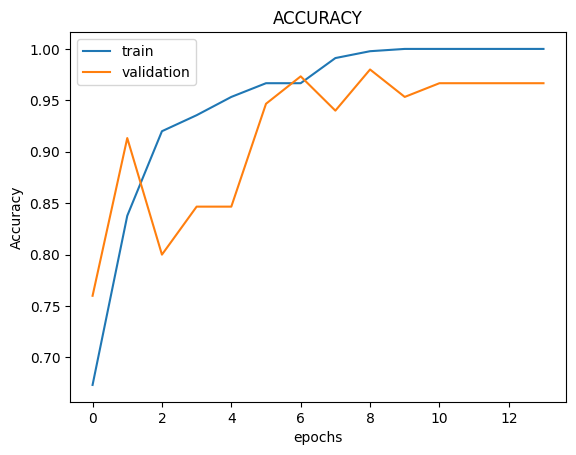

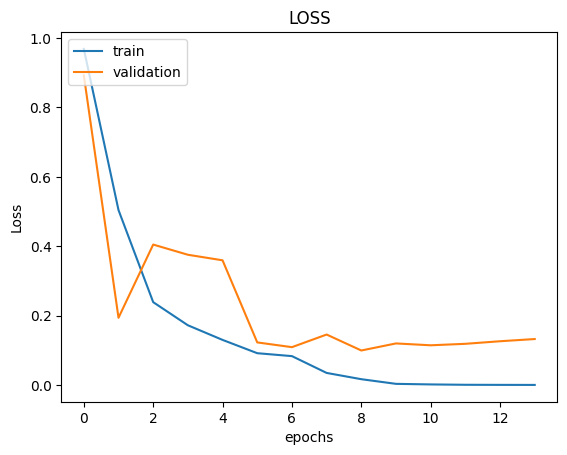

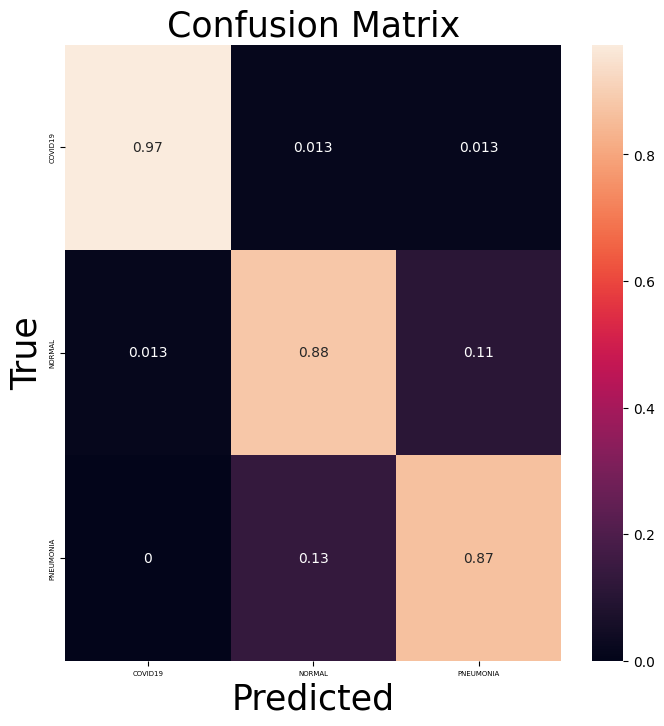

In [51]:
# Resnet50 from Imagenet (all layers)

model = torchvision.models.resnet50(weights=torchvision.models.ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(2048, num_classes)
model = model.to(device)

# new datasets with imagenet mean and std

# https://pytorch.org/vision/main/models/generated/torchvision.models.resnet50.html
imagenet_mean = (0.485, 0.456, 0.406)
imagenet_std = (0.229, 0.224, 0.225)

transform = get_transforms(height, width, imagenet_mean, imagenet_std)

# Datasets
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=transform)
test_dataset = torchvision.datasets.ImageFolder(root=test_dir, transform=transform)

# Dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

# train as usual
train(model, 'resnet50-imagenet_all_layers', train_loader, val_loader, test_loader, 30, device, classes, root_dir)

## <span style="color:#228B22">Results</span>

The `unknown` set corresponds to a hold-out test set (with unlabeled images). Such unseen test data is common in machine learning challenges to ensure an objective comparison of different methods and to test how well these solutions would generalize to real data.

The results are in the following format:
- `Results.csv`
    - patient_\<ID-1>.jpg | \<CLASS-1>
    - patient_\<ID-2>.jpg | \<CLASS-2> <br>
    . <br>
    . <br>
    . <br>
    - patient_\<ID_n>.jpg | \<CLASS-[1-3]>
 
Below is a function that generates the predictions.

In [52]:
filename = "Results.csv"

# Function generating predictions (in a csv file) for the respective images in the hold-out test set (`unknown` folder)
# Note: if you want to use test-time-augmentation or model ensembling you may need to update this function.
# If you don't want to update it you can also create a new class that implements a wrapper around the model(s)
# that implements the augmentation or ensembling logic.

#utils.predict_unknown(model, height, width, train_dataset_mean, train_dataset_std, unknown_dir, device, filename)
utils.predict_unknown(model, height, width, imagenet_mean, imagenet_std, unknown_dir, device, filename)

# Download link is automatically generated for the final results generated
FileLink(filename)

  0%|          | 0/5607 [00:00<?, ?it/s]/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
100%|██████████| 5607/5607 [01:06<00:00, 84.89it/s]


/kaggle/working/Results.csv